# Stage 3 모델 비교 실험: AttriMIL vs Attention MIL vs Gated Attention MIL

이 노트북은 Stage 2에서 생성한 MIL Bag 데이터를 입력으로 받아 세 가지 MIL 모델을 비교 실험합니다:
1. **기본 Attention MIL**: 단순한 attention mechanism 
2. **Gated Attention MIL**: Gate를 통해 attention을 조절하는 모델
3. **AttriMIL**: Multi-branch Attribute-aware MIL (클래스별 attention branch)

**AttriMIL 핵심 특징:**
- Multi-branch attribute scoring mechanism
- 각 클래스별로 독립적인 attention branch
- Gated attention mechanism 활용
- Instance 속성을 더 정확하게 포착

**실험 목표:**
- AttriMIL의 multi-branch 구조 효과 검증
- 클래스별 attention 패턴 분석
- 기존 모델 대비 성능 향상 평가

**References:**
- AttriMIL: https://github.com/MedCAI/AttriMIL

In [1]:
# 환경 설정
import os
import random
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, roc_curve, confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# GPU 설정
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = os.getenv('MIL_STAGE3_GPU', '3')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
if device.type == 'cuda':
    print('GPU:', torch.cuda.get_device_name(0))
else:
    print('CUDA를 사용할 수 없습니다. CPU 모드로 실행됩니다.')

# 시드 고정 유틸리티 함수 추가
def seed_everything(seed=42):
    """모든 난수 생성기 시드를 고정하는 함수"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    print(f"🔒 모든 시드를 {seed}로 고정완료")

# 초기 시드 고정
seed_everything(42)

Using device: cuda
GPU: NVIDIA GeForce RTX 3090
🔒 모든 시드를 42로 고정완료


In [2]:
# Stage 2 Bag 데이터 로드 및 Instance 평균 계산
embedding_margin = '0.4'
bags_dir = '/workspace/MIL/data/processed/bags'
train_pkl = os.path.join(bags_dir, f'bags_arcface_margin_{embedding_margin}_50p_random_train.pkl')
val_pkl   = os.path.join(bags_dir, f'bags_arcface_margin_{embedding_margin}_50p_random_val.pkl')
test_pkl  = os.path.join(bags_dir, f'bags_arcface_margin_{embedding_margin}_50p_random_test.pkl')

print('Loading MIL bags...')
with open(train_pkl, 'rb') as f:
    train_data = pickle.load(f)
with open(val_pkl, 'rb') as f:
    val_data = pickle.load(f)
with open(test_pkl, 'rb') as f:
    test_data = pickle.load(f)

# Instance mean 계산: (10,5,256) → (10,256)
def to_instance_means(bags):
    return [bag.mean(axis=1).astype(np.float32) for bag in bags]

train_features = to_instance_means(train_data['bags'])
val_features   = to_instance_means(val_data['bags'])
test_features  = to_instance_means(test_data['bags'])

train_labels = train_data['labels']
val_labels   = val_data['labels']
test_labels  = test_data['labels']

print(f'Train bags: {len(train_labels)}, Val bags: {len(val_labels)}, Test bags: {len(test_labels)}')

Loading MIL bags...
Train bags: 3600, Val bags: 1200, Test bags: 1200


In [3]:
# Dataset 클래스 (on‑the‑fly Tensor 변환)

class MILDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features  # list of np.ndarray
        self.labels = labels      # list of int
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        x = torch.tensor(self.features[idx], dtype=torch.float32)
        y = torch.tensor(self.labels[idx], dtype=torch.float32)
        return x, y

batch_size = 16
train_loader = DataLoader(MILDataset(train_features, train_labels), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(MILDataset(val_features,   val_labels),   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(MILDataset(test_features,  test_labels),  batch_size=batch_size, shuffle=False)

In [4]:
# WeightedBCE 손실함수 정의 (baseline과 동일한 설정)

class WeightedBCE(nn.Module):
    """Weighted Binary Cross Entropy Loss - False Positive에 더 큰 가중치 부여"""
    def __init__(self, fp_weight=2.0):
        super().__init__()
        self.fp_weight = fp_weight
        self.bce = nn.BCEWithLogitsLoss(reduction='none')
    
    def forward(self, logits, labels):
        loss = self.bce(logits, labels)
        # False Positive (label=0인데 예측이 1)에 더 큰 가중치
        fp_mask = (labels == 0).float()
        loss = loss * (1 + self.fp_weight * fp_mask)
        return loss.mean()

print("✅ WeightedBCE 손실함수 클래스 정의 완료")
print(f"   FP Weight: 2.0 (baseline과 동일)")

✅ WeightedBCE 손실함수 클래스 정의 완료
   FP Weight: 2.0 (baseline과 동일)


In [5]:
# AttriMIL 모델 구현

class AttentionGated(nn.Module):
    """Gated Attention Network for AttriMIL"""
    def __init__(self, input_dim, hidden_dim=128):
        super().__init__()
        self.attention_a = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh()
        )
        self.attention_b = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Sigmoid()
        )
        self.attention_c = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        a = self.attention_a(x)
        b = self.attention_b(x)
        A = a.mul(b)
        A = self.attention_c(A)  # (B, N, 1)
        return A

class AttriMIL(nn.Module):
    """Attribute-aware Multiple Instance Learning
    
    Multi-branch attribute scoring mechanism으로 각 클래스별로
    독립적인 attention branch를 사용하여 instance의 속성을 정확하게 파악
    
    References:
        - https://github.com/MedCAI/AttriMIL
    """
    def __init__(self, input_dim=256, hidden_dim=128, n_classes=2, dropout_p=0.1):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.n_classes = n_classes
        
        # Feature transformation (adaptor)
        self.adaptor = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_p)
        )
        
        # Multi-branch attention networks (one per class)
        self.attention_branches = nn.ModuleList([
            AttentionGated(hidden_dim, hidden_dim//2) for _ in range(n_classes)
        ])
        
        # Instance-level classifiers (one per class)
        self.instance_classifiers = nn.ModuleList([
            nn.Linear(hidden_dim, 1) for _ in range(n_classes)
        ])
        
        # Learnable bias parameter for each class
        self.bias = nn.Parameter(torch.zeros(n_classes))
        
        # Dropout
        self.dropout = nn.Dropout(dropout_p)
        
        self._init_weights()
    
    def _init_weights(self):
        # Initialize weights using Xavier initialization
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
    
    def forward(self, x, return_features=False):
        # x: (B, N, input_dim)
        batch_size = x.size(0)
        
        # Feature transformation
        h = self.adaptor(x)  # (B, N, hidden_dim)
        
        # Multi-branch attribute scoring
        all_scores = []
        all_attention = []
        
        for c in range(self.n_classes):
            # Compute attention weights for class c
            A_c = self.attention_branches[c](h)  # (B, N, 1)
            A_c = torch.transpose(A_c, 1, 2)  # (B, 1, N)
            A_c = F.softmax(A_c, dim=2)  # (B, 1, N)
            
            # Instance-level predictions for class c
            instance_scores = self.instance_classifiers[c](h)  # (B, N, 1)
            instance_scores = torch.transpose(instance_scores, 1, 2)  # (B, 1, N)
            
            # Attribute score: weighted sum of instance scores
            # This represents how much the bag exhibits attributes of class c
            attribute_score = torch.matmul(A_c, torch.transpose(instance_scores, 1, 2))  # (B, 1, 1)
            attribute_score = attribute_score.squeeze()  # (B,)
            
            all_scores.append(attribute_score)
            all_attention.append(A_c.squeeze(1))  # (B, N)
        
        # Stack scores for all classes
        logits = torch.stack(all_scores, dim=1)  # (B, n_classes)
        
        # Add learnable bias
        logits = logits + self.bias
        
        # For binary classification, extract single logit
        if self.n_classes == 2:
            # Use difference between positive and negative class scores
            binary_logit = logits[:, 1] - logits[:, 0]  # (B,)
            
            # Average attention from both branches for visualization
            avg_attention = torch.stack(all_attention, dim=0).mean(dim=0)  # (B, N)
            
            if return_features:
                return binary_logit, avg_attention, all_attention
            return binary_logit, avg_attention
        else:
            # Multi-class: return all logits
            return logits, all_attention

print("✅ AttriMIL 모델 클래스 정의 완료:")
print("  - Multi-branch attribute scoring mechanism")
print("  - 클래스별 독립적인 attention branch")
print("  - Gated attention mechanism")
print("  - Instance-level classifiers")

✅ AttriMIL 모델 클래스 정의 완료:
  - Multi-branch attribute scoring mechanism
  - 클래스별 독립적인 attention branch
  - Gated attention mechanism
  - Instance-level classifiers


In [6]:
# 기존 모델들 정의 (비교를 위해)

class AttentionMIL(nn.Module):
    """기본 Attention-based MIL 모델"""
    def __init__(self, input_dim=256, hidden_dim=128, dropout_p=0.1):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        
        # Instance-level feature transformation
        self.instance_fc = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_p)
        
        # Attention mechanism
        self.att_fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.att_fc2 = nn.Linear(hidden_dim, 1)
        
        # Classifier
        self.classifier = nn.Linear(hidden_dim, 1)
        self._init_weights()
    
    def _init_weights(self):
        nn.init.kaiming_uniform_(self.instance_fc.weight, nonlinearity='relu')
        nn.init.zeros_(self.instance_fc.bias)
        nn.init.xavier_uniform_(self.att_fc1.weight)
        nn.init.zeros_(self.att_fc1.bias)
        nn.init.xavier_uniform_(self.att_fc2.weight)
        nn.init.zeros_(self.att_fc2.bias)
        nn.init.xavier_uniform_(self.classifier.weight)
        nn.init.zeros_(self.classifier.bias)
    
    def forward(self, x):
        h = torch.relu(self.instance_fc(x))
        h = self.dropout(h)
        
        a = torch.tanh(self.att_fc1(h))
        a = self.att_fc2(a).squeeze(-1)
        weights = torch.softmax(a, dim=1)
        
        bag_repr = torch.sum(weights.unsqueeze(-1) * h, dim=1)
        bag_repr = self.dropout(bag_repr)
        
        logits = self.classifier(bag_repr).squeeze(-1)
        return logits, weights

class GatedAttentionMIL(nn.Module):
    """Gated Attention MIL 모델"""
    def __init__(self, input_dim=256, hidden_dim=128, dropout_p=0.1):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        
        self.instance_fc = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_p)
        
        self.attention_fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.attention_fc2 = nn.Linear(hidden_dim, 1)
        
        self.gate_fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.gate_fc2 = nn.Linear(hidden_dim, 1)
        
        self.classifier = nn.Linear(hidden_dim, 1)
        self._init_weights()
    
    def _init_weights(self):
        nn.init.kaiming_uniform_(self.instance_fc.weight, nonlinearity='relu')
        nn.init.zeros_(self.instance_fc.bias)
        nn.init.xavier_uniform_(self.attention_fc1.weight)
        nn.init.zeros_(self.attention_fc1.bias)
        nn.init.xavier_uniform_(self.attention_fc2.weight)
        nn.init.zeros_(self.attention_fc2.bias)
        nn.init.xavier_uniform_(self.gate_fc1.weight)
        nn.init.zeros_(self.gate_fc1.bias)
        nn.init.xavier_uniform_(self.gate_fc2.weight)
        nn.init.zeros_(self.gate_fc2.bias)
        nn.init.xavier_uniform_(self.classifier.weight)
        nn.init.zeros_(self.classifier.bias)
    
    def forward(self, x):
        h = torch.relu(self.instance_fc(x))
        h = self.dropout(h)
        
        attention = torch.tanh(self.attention_fc1(h))
        attention_scores = self.attention_fc2(attention)
        
        gate = torch.tanh(self.gate_fc1(h))
        gate_scores = torch.sigmoid(self.gate_fc2(gate))
        
        gated_attention = attention_scores * gate_scores
        gated_attention = gated_attention.squeeze(-1)
        
        weights = torch.softmax(gated_attention, dim=1)
        
        bag_repr = torch.sum(weights.unsqueeze(-1) * h, dim=1)
        bag_repr = self.dropout(bag_repr)
        
        logits = self.classifier(bag_repr).squeeze(-1)
        return logits, weights

print("✅ 비교 모델 클래스 정의 완료:")
print("  - AttentionMIL: 기본 attention mechanism")
print("  - GatedAttentionMIL: Gate로 조절되는 attention mechanism")

✅ 비교 모델 클래스 정의 완료:
  - AttentionMIL: 기본 attention mechanism
  - GatedAttentionMIL: Gate로 조절되는 attention mechanism


In [7]:
# 모델 학습 및 평가 함수

def is_attention_model(model):
    """Attention 기반 모델인지 확인"""
    return isinstance(model, (AttentionMIL, GatedAttentionMIL, AttriMIL))

def train_one_epoch(model, optimizer, loader, criterion):
    model.train()
    total_loss = 0.0
    preds_all = []
    labels_all = []
    
    for X, y in tqdm(loader, desc='Train', leave=False):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        
        if is_attention_model(model):
            logits, _ = model(X)
        else:
            logits = model(X)
            
        loss = criterion(logits, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item() * y.size(0)
        preds = (torch.sigmoid(logits) >= 0.5).float()
        preds_all.extend(preds.cpu().numpy())
        labels_all.extend(y.cpu().numpy())
    
    return total_loss / len(loader.dataset), accuracy_score(labels_all, preds_all)

def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    probs_all = []
    preds_all = []
    labels_all = []
    attention_weights_all = []
    
    with torch.no_grad():
        for X, y in tqdm(loader, desc='Eval', leave=False):
            X, y = X.to(device), y.to(device)
            
            if is_attention_model(model):
                logits, attention_weights = model(X)
                attention_weights_all.append(attention_weights.cpu().numpy())
            else:
                logits = model(X)
                
            loss = criterion(logits, y)
            total_loss += loss.item() * y.size(0)
            
            probs = torch.sigmoid(logits)
            preds = (probs >= 0.5).float()
            
            probs_all.extend(probs.cpu().numpy())
            preds_all.extend(preds.cpu().numpy())
            labels_all.extend(y.cpu().numpy())
    
    acc = accuracy_score(labels_all, preds_all)
    auc = roc_auc_score(labels_all, probs_all) if len(set(labels_all)) > 1 else 0.0
    f1 = f1_score(labels_all, preds_all) if len(set(preds_all)) > 1 else 0.0
    
    attention_weights_combined = np.concatenate(attention_weights_all, axis=0) if attention_weights_all else None
    
    return {
        'loss': total_loss / len(loader.dataset),
        'accuracy': acc,
        'auc': auc,
        'f1': f1,
        'probs': np.array(probs_all),
        'labels': np.array(labels_all),
        'preds': np.array(preds_all),
        'attention_weights': attention_weights_combined
    }

def train_model(model, optimizer, scheduler, train_loader, val_loader, criterion, 
                max_epochs=10, patience=3, name='model'):
    """모델 학습 (Early Stopping 포함)"""
    best_auc = 0.0
    best_state = None
    epochs_no_improve = 0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'val_auc': [], 'val_f1': []}
    
    print(f"\n🚀 {name} 모델 학습 시작...")
    print(f"   Max epochs: {max_epochs}, Patience: {patience}")
    
    for epoch in range(1, max_epochs + 1):
        print(f"\nEpoch {epoch}/{max_epochs} – {name}")
        
        tr_loss, tr_acc = train_one_epoch(model, optimizer, train_loader, criterion)
        val_results = evaluate(model, val_loader, criterion)
        val_loss, val_acc, val_auc, val_f1 = val_results['loss'], val_results['accuracy'], val_results['auc'], val_results['f1']
        
        history['train_loss'].append(tr_loss)
        history['train_acc'].append(tr_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_auc'].append(val_auc)
        history['val_f1'].append(val_f1)
        
        print(f"  Train: Loss={tr_loss:.4f}, Acc={tr_acc:.4f}")
        print(f"  Val:   Loss={val_loss:.4f}, Acc={val_acc:.4f}, AUC={val_auc:.4f}, F1={val_f1:.4f}")
        
        scheduler.step(val_auc)
        
        if val_auc > best_auc:
            best_auc = val_auc
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}
            torch.save(best_state, f'best_{name}.pth')
            print(f"  ✅ New best AUC: {best_auc:.4f} – model saved.")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"  ⏳ No improvement. Patience: {epochs_no_improve}/{patience}")
            if epochs_no_improve >= patience:
                print("  🛑 Early stopping triggered.")
                break
    
    if best_state is not None:
        model.load_state_dict(best_state)
        print(f"  📂 Best model loaded (AUC: {best_auc:.4f})")
    
    return model, history

print("✅ 학습/평가 함수 정의 완료")

✅ 학습/평가 함수 정의 완료


In [8]:
# 모델 비교 실험: AttriMIL vs Gated Attention MIL vs Attention MIL

# 손실함수
criterion = WeightedBCE(fp_weight=2.0)

# 실험 설정
learning_rate = 1e-3
max_epochs = 10
patience = 3
scheduler_patience = 1

print("🔬 모델 비교 실험 시작")
print("=" * 60)
print(f"손실 함수: WeightedBCE(fp_weight=2.0)")
print(f"학습률: {learning_rate}")
print(f"최대 에포크: {max_epochs}, Patience: {patience}")
print(f"Scheduler Patience: {scheduler_patience}")
print("=" * 60)

# 모델별 결과 저장
model_results = {}
model_histories = {}

# 1. AttriMIL 모델 학습
seed_everything(42)
print("\n1️⃣ AttriMIL (Attribute-aware MIL) 모델")
attrimil_model = AttriMIL(input_dim=256, hidden_dim=128, n_classes=2, dropout_p=0.1).to(device)
attrimil_optimizer = torch.optim.Adam(attrimil_model.parameters(), lr=learning_rate)
attrimil_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    attrimil_optimizer, mode='max', factor=0.5, patience=scheduler_patience, verbose=True
)

attrimil_model, attrimil_history = train_model(
    attrimil_model, attrimil_optimizer, attrimil_scheduler,
    train_loader, val_loader, criterion,
    max_epochs=max_epochs, patience=patience, name='attrimil'
)

# AttriMIL 평가
val_results_attrimil = evaluate(attrimil_model, val_loader, criterion)
test_results_attrimil = evaluate(attrimil_model, test_loader, criterion)

model_results['AttriMIL'] = {
    'val': val_results_attrimil,
    'test': test_results_attrimil,
    'model': attrimil_model
}
model_histories['AttriMIL'] = attrimil_history

print(f"\n✅ AttriMIL 완료")
print(f"   Val AUC: {val_results_attrimil['auc']:.4f}")
print(f"   Test AUC: {test_results_attrimil['auc']:.4f}")

# 2. Gated Attention MIL 모델 학습
seed_everything(42)
print("\n2️⃣ Gated Attention MIL 모델")
gated_model = GatedAttentionMIL(input_dim=256, hidden_dim=128, dropout_p=0.1).to(device)
gated_optimizer = torch.optim.Adam(gated_model.parameters(), lr=learning_rate)
gated_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    gated_optimizer, mode='max', factor=0.5, patience=scheduler_patience, verbose=True
)

gated_model, gated_history = train_model(
    gated_model, gated_optimizer, gated_scheduler,
    train_loader, val_loader, criterion,
    max_epochs=max_epochs, patience=patience, name='gated_attention'
)

# Gated 평가
val_results_gated = evaluate(gated_model, val_loader, criterion)
test_results_gated = evaluate(gated_model, test_loader, criterion)

model_results['Gated_Attention'] = {
    'val': val_results_gated,
    'test': test_results_gated,
    'model': gated_model
}
model_histories['Gated_Attention'] = gated_history

print(f"\n✅ Gated Attention MIL 완료")
print(f"   Val AUC: {val_results_gated['auc']:.4f}")
print(f"   Test AUC: {test_results_gated['auc']:.4f}")

# 3. 기본 Attention MIL 모델 학습
seed_everything(42)
print("\n3️⃣ 기본 Attention MIL 모델")
attention_model = AttentionMIL(input_dim=256, hidden_dim=128, dropout_p=0.1).to(device)
attention_optimizer = torch.optim.Adam(attention_model.parameters(), lr=learning_rate)
attention_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    attention_optimizer, mode='max', factor=0.5, patience=scheduler_patience, verbose=True
)

attention_model, attention_history = train_model(
    attention_model, attention_optimizer, attention_scheduler,
    train_loader, val_loader, criterion,
    max_epochs=max_epochs, patience=patience, name='basic_attention'
)

# Attention 평가
val_results_attention = evaluate(attention_model, val_loader, criterion)
test_results_attention = evaluate(attention_model, test_loader, criterion)

model_results['Basic_Attention'] = {
    'val': val_results_attention,
    'test': test_results_attention,
    'model': attention_model
}
model_histories['Basic_Attention'] = attention_history

print(f"\n✅ Basic Attention MIL 완료")
print(f"   Val AUC: {val_results_attention['auc']:.4f}")
print(f"   Test AUC: {test_results_attention['auc']:.4f}")

print("\n" + "="*60)
print("🏆 모든 모델 학습 완료!")
print("="*60)

🔬 모델 비교 실험 시작
손실 함수: WeightedBCE(fp_weight=2.0)
학습률: 0.001
최대 에포크: 10, Patience: 3
Scheduler Patience: 1
🔒 모든 시드를 42로 고정완료

1️⃣ AttriMIL (Attribute-aware MIL) 모델


/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



🚀 attrimil 모델 학습 시작...
   Max epochs: 10, Patience: 3

Epoch 1/10 – attrimil


  Train: Loss=1.1075, Acc=0.4992
  Val:   Loss=1.0640, Acc=0.5000, AUC=0.7697, F1=0.0000
  ✅ New best AUC: 0.7697 – model saved.

Epoch 2/10 – attrimil


  Train: Loss=0.9773, Acc=0.5206
  Val:   Loss=0.9785, Acc=0.5392, AUC=0.7928, F1=0.1659
  ✅ New best AUC: 0.7928 – model saved.

Epoch 3/10 – attrimil


  Train: Loss=0.8576, Acc=0.6381
  Val:   Loss=0.9134, Acc=0.5983, AUC=0.8150, F1=0.3573
  ✅ New best AUC: 0.8150 – model saved.

Epoch 4/10 – attrimil


  Train: Loss=0.7776, Acc=0.6872
  Val:   Loss=0.9251, Acc=0.6900, AUC=0.8113, F1=0.5957
  ⏳ No improvement. Patience: 1/3

Epoch 5/10 – attrimil


  Train: Loss=0.7116, Acc=0.7214
  Val:   Loss=0.9197, Acc=0.7233, AUC=0.8219, F1=0.6706
  ✅ New best AUC: 0.8219 – model saved.

Epoch 6/10 – attrimil


  Train: Loss=0.6598, Acc=0.7475
  Val:   Loss=0.9678, Acc=0.7375, AUC=0.8101, F1=0.7097
  ⏳ No improvement. Patience: 1/3

Epoch 7/10 – attrimil


  Train: Loss=0.6096, Acc=0.7731
  Val:   Loss=1.0064, Acc=0.7417, AUC=0.8202, F1=0.7295
  ⏳ No improvement. Patience: 2/3

Epoch 8/10 – attrimil


  Train: Loss=0.5643, Acc=0.7917
  Val:   Loss=1.0154, Acc=0.7458, AUC=0.8218, F1=0.7346
  ⏳ No improvement. Patience: 3/3
  🛑 Early stopping triggered.
  📂 Best model loaded (AUC: 0.8219)


/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



✅ AttriMIL 완료
   Val AUC: 0.8219
   Test AUC: 0.8284
🔒 모든 시드를 42로 고정완료

2️⃣ Gated Attention MIL 모델

🚀 gated_attention 모델 학습 시작...
   Max epochs: 10, Patience: 3

Epoch 1/10 – gated_attention


  Train: Loss=1.1293, Acc=0.4997
  Val:   Loss=1.0945, Acc=0.5000, AUC=0.6864, F1=0.0000
  ✅ New best AUC: 0.6864 – model saved.

Epoch 2/10 – gated_attention


  Train: Loss=1.0399, Acc=0.5000
  Val:   Loss=1.0374, Acc=0.5000, AUC=0.7841, F1=0.0000
  ✅ New best AUC: 0.7841 – model saved.

Epoch 3/10 – gated_attention


  Train: Loss=0.9763, Acc=0.5000
  Val:   Loss=1.0042, Acc=0.5000, AUC=0.8090, F1=0.0000
  ✅ New best AUC: 0.8090 – model saved.

Epoch 4/10 – gated_attention


  Train: Loss=0.9289, Acc=0.5000
  Val:   Loss=0.9794, Acc=0.5000, AUC=0.8237, F1=0.0000
  ✅ New best AUC: 0.8237 – model saved.

Epoch 5/10 – gated_attention


  Train: Loss=0.8781, Acc=0.5175
  Val:   Loss=0.9851, Acc=0.5483, AUC=0.8238, F1=0.1935
  ✅ New best AUC: 0.8238 – model saved.

Epoch 6/10 – gated_attention


  Train: Loss=0.8258, Acc=0.5608
  Val:   Loss=0.9754, Acc=0.6258, AUC=0.8271, F1=0.4464
  ✅ New best AUC: 0.8271 – model saved.

Epoch 7/10 – gated_attention


  Train: Loss=0.7805, Acc=0.6100
  Val:   Loss=0.9783, Acc=0.7000, AUC=0.8223, F1=0.6203
  ⏳ No improvement. Patience: 1/3

Epoch 8/10 – gated_attention


  Train: Loss=0.7326, Acc=0.6681
  Val:   Loss=1.0204, Acc=0.7633, AUC=0.8280, F1=0.7365
  ✅ New best AUC: 0.8280 – model saved.

Epoch 9/10 – gated_attention


  Train: Loss=0.6809, Acc=0.7469
  Val:   Loss=1.0615, Acc=0.7617, AUC=0.8256, F1=0.7679
  ⏳ No improvement. Patience: 1/3

Epoch 10/10 – gated_attention


  Train: Loss=0.6306, Acc=0.7936
  Val:   Loss=1.1686, Acc=0.7292, AUC=0.8216, F1=0.7612
  ⏳ No improvement. Patience: 2/3
  📂 Best model loaded (AUC: 0.8280)


/opt/conda/envs/py38/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



✅ Gated Attention MIL 완료
   Val AUC: 0.8280
   Test AUC: 0.8419
🔒 모든 시드를 42로 고정완료

3️⃣ 기본 Attention MIL 모델

🚀 basic_attention 모델 학습 시작...
   Max epochs: 10, Patience: 3

Epoch 1/10 – basic_attention


  Train: Loss=1.1343, Acc=0.4975
  Val:   Loss=1.0953, Acc=0.5000, AUC=0.6773, F1=0.0000
  ✅ New best AUC: 0.6773 – model saved.

Epoch 2/10 – basic_attention


  Train: Loss=1.0570, Acc=0.5000
  Val:   Loss=1.0589, Acc=0.5000, AUC=0.7313, F1=0.0000
  ✅ New best AUC: 0.7313 – model saved.

Epoch 3/10 – basic_attention


  Train: Loss=1.0005, Acc=0.5000
  Val:   Loss=1.0163, Acc=0.5000, AUC=0.7866, F1=0.0000
  ✅ New best AUC: 0.7866 – model saved.

Epoch 4/10 – basic_attention


  Train: Loss=0.9530, Acc=0.5000
  Val:   Loss=0.9869, Acc=0.5000, AUC=0.7939, F1=0.0000
  ✅ New best AUC: 0.7939 – model saved.

Epoch 5/10 – basic_attention


  Train: Loss=0.9208, Acc=0.5114
  Val:   Loss=0.9787, Acc=0.5242, AUC=0.7959, F1=0.1008
  ✅ New best AUC: 0.7959 – model saved.

Epoch 6/10 – basic_attention


  Train: Loss=0.8835, Acc=0.5381
  Val:   Loss=0.9694, Acc=0.5833, AUC=0.8116, F1=0.3132
  ✅ New best AUC: 0.8116 – model saved.

Epoch 7/10 – basic_attention


  Train: Loss=0.8526, Acc=0.5739
  Val:   Loss=0.9688, Acc=0.6208, AUC=0.8107, F1=0.4485
  ⏳ No improvement. Patience: 1/3

Epoch 8/10 – basic_attention


  Train: Loss=0.8158, Acc=0.6111
  Val:   Loss=0.9471, Acc=0.6575, AUC=0.8169, F1=0.5281
  ✅ New best AUC: 0.8169 – model saved.

Epoch 9/10 – basic_attention


  Train: Loss=0.7723, Acc=0.6506
  Val:   Loss=0.9764, Acc=0.7308, AUC=0.8142, F1=0.6950
  ⏳ No improvement. Patience: 1/3

Epoch 10/10 – basic_attention


  Train: Loss=0.7071, Acc=0.7392
  Val:   Loss=1.0678, Acc=0.7467, AUC=0.8159, F1=0.7548
  ⏳ No improvement. Patience: 2/3
  📂 Best model loaded (AUC: 0.8169)



✅ Basic Attention MIL 완료
   Val AUC: 0.8169
   Test AUC: 0.8381

🏆 모든 모델 학습 완료!


In [9]:
# 모델 성능 비교 및 결과 분석

from sklearn.metrics import precision_score, recall_score

# 최적 임계값 찾기 함수
def find_best_threshold(probs, labels):
    best_thr, best_val = 0.5, 0.0
    for thr in np.linspace(0.05, 0.95, 37):
        preds = (probs >= thr).astype(int)
        val = f1_score(labels, preds, zero_division=0)
        if val > best_val:
            best_val, best_thr = val, thr
    return best_thr, best_val

# 각 모델의 최적 임계값을 validation set에서 찾고 test set에 적용
final_results = {}

print("\n📊 모델별 최종 성능 비교")
print("=" * 80)

for model_name, results in model_results.items():
    val_results = results['val']
    test_results = results['test']
    
    best_thr, best_f1_val = find_best_threshold(val_results['probs'], val_results['labels'])
    test_preds_adj = (test_results['probs'] >= best_thr).astype(int)
    
    final_acc = accuracy_score(test_results['labels'], test_preds_adj)
    final_f1 = f1_score(test_results['labels'], test_preds_adj, zero_division=0)
    final_precision = precision_score(test_results['labels'], test_preds_adj, zero_division=0)
    final_recall = recall_score(test_results['labels'], test_preds_adj, zero_division=0)
    final_auc = test_results['auc']
    
    final_results[model_name] = {
        'threshold': best_thr,
        'accuracy': final_acc,
        'f1': final_f1,
        'precision': final_precision,
        'recall': final_recall,
        'auc': final_auc,
        'test_probs': test_results['probs'],
        'test_labels': test_results['labels'],
        'test_preds_adj': test_preds_adj
    }
    
    print(f"\n{model_name}:")
    print(f"  최적 임계값: {best_thr:.3f} (Val F1: {best_f1_val:.3f})")
    print(f"  Test Accuracy: {final_acc:.3f}")
    print(f"  Test F1: {final_f1:.3f}")
    print(f"  Test Precision: {final_precision:.3f}")
    print(f"  Test Recall: {final_recall:.3f}")
    print(f"  Test AUC: {final_auc:.3f}")

# 성능 비교 테이블
print("\n" + "=" * 80)
print("📈 모델 성능 요약 테이블")
print("=" * 80)
print(f"{'Model':<20} {'Accuracy':<10} {'F1':<8} {'Precision':<11} {'Recall':<8} {'AUC':<8}")
print("-" * 80)

for model_name, results in final_results.items():
    print(f"{model_name:<20} {results['accuracy']:<10.3f} {results['f1']:<8.3f} "
          f"{results['precision']:<11.3f} {results['recall']:<8.3f} {results['auc']:<8.3f}")

# 최고 성능 모델 찾기
best_model_auc = max(final_results.items(), key=lambda x: x[1]['auc'])
best_model_f1 = max(final_results.items(), key=lambda x: x[1]['f1'])

print(f"\n🏆 최고 성능:")
print(f"  AUC 기준: {best_model_auc[0]} (AUC: {best_model_auc[1]['auc']:.3f})")
print(f"  F1 기준:  {best_model_f1[0]} (F1: {best_model_f1[1]['f1']:.3f})")

print("\n✅ 성능 분석 완료!")


📊 모델별 최종 성능 비교

AttriMIL:
  최적 임계값: 0.300 (Val F1: 0.761)
  Test Accuracy: 0.731
  Test F1: 0.762
  Test Precision: 0.682
  Test Recall: 0.863
  Test AUC: 0.828

Gated_Attention:
  최적 임계값: 0.400 (Val F1: 0.771)
  Test Accuracy: 0.711
  Test F1: 0.759
  Test Precision: 0.651
  Test Recall: 0.910
  Test AUC: 0.842

Basic_Attention:
  최적 임계값: 0.275 (Val F1: 0.763)
  Test Accuracy: 0.682
  Test F1: 0.748
  Test Precision: 0.620
  Test Recall: 0.942
  Test AUC: 0.838

📈 모델 성능 요약 테이블
Model                Accuracy   F1       Precision   Recall   AUC     
--------------------------------------------------------------------------------
AttriMIL             0.731      0.762    0.682       0.863    0.828   
Gated_Attention      0.711      0.759    0.651       0.910    0.842   
Basic_Attention      0.682      0.748    0.620       0.942    0.838   

🏆 최고 성능:
  AUC 기준: Gated_Attention (AUC: 0.842)
  F1 기준:  AttriMIL (F1: 0.762)

✅ 성능 분석 완료!


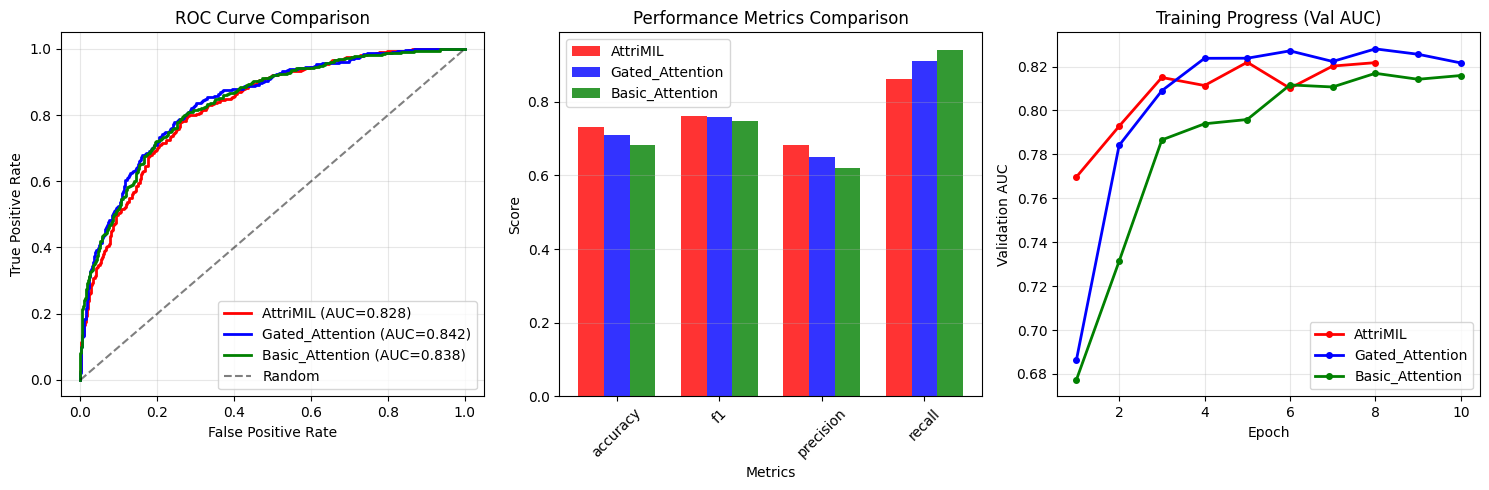

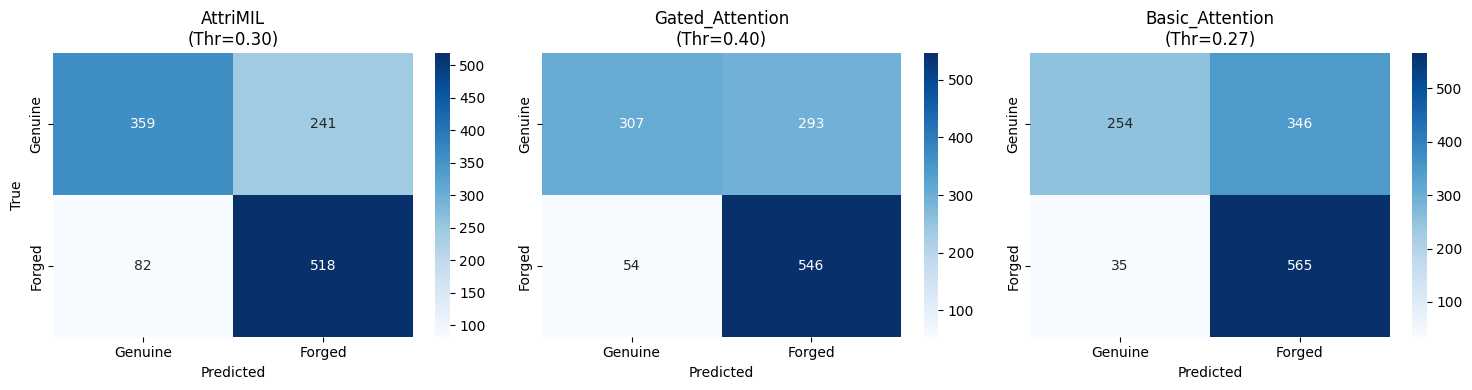


🎉 시각화 완료!


In [10]:
# 시각화: ROC 곡선, Confusion Matrix, 학습 곡선 비교

from sklearn.metrics import auc

# 1. ROC 곡선 비교
plt.figure(figsize=(15, 5))

# ROC 곡선
plt.subplot(1, 3, 1)
colors = ['red', 'blue', 'green']
model_names = list(final_results.keys())

for i, (model_name, results) in enumerate(final_results.items()):
    fpr, tpr, _ = roc_curve(results['test_labels'], results['test_probs'])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], linewidth=2, 
             label=f'{model_name} (AUC={auc_score:.3f})')

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. 성능 메트릭 비교 (Bar plot)
plt.subplot(1, 3, 2)
metrics = ['accuracy', 'f1', 'precision', 'recall']
x = np.arange(len(metrics))
width = 0.25

for i, (model_name, results) in enumerate(final_results.items()):
    values = [results[metric] for metric in metrics]
    plt.bar(x + i*width, values, width, label=model_name, color=colors[i], alpha=0.8)

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Performance Metrics Comparison')
plt.xticks(x + width, metrics, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

# 3. 학습 곡선 비교 (AUC)
plt.subplot(1, 3, 3)
for i, (model_name, history) in enumerate(model_histories.items()):
    epochs = range(1, len(history['val_auc']) + 1)
    plt.plot(epochs, history['val_auc'], 'o-', color=colors[i], 
             linewidth=2, label=f'{model_name}', markersize=4)

plt.xlabel('Epoch')
plt.ylabel('Validation AUC')
plt.title('Training Progress (Val AUC)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Confusion Matrix 비교
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, (model_name, results) in enumerate(final_results.items()):
    cm = confusion_matrix(results['test_labels'].astype(int), 
                         results['test_preds_adj'].astype(int), 
                         labels=[0, 1])
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=['Genuine', 'Forged'], 
                yticklabels=['Genuine', 'Forged'])
    axes[i].set_title(f'{model_name}\n(Thr={results["threshold"]:.2f})')
    axes[i].set_xlabel('Predicted')
    if i == 0:
        axes[i].set_ylabel('True')

plt.tight_layout()
plt.show()

print("\n🎉 시각화 완료!")

In [11]:
# AttriMIL 특별 분석: 클래스별 Attention 패턴

print("\n🔍 AttriMIL 클래스별 Attention 분석")
print("=" * 50)

# AttriMIL의 클래스별 attention을 분석하기 위해 몇 개 샘플 추출
attrimil_model.eval()
sample_loader = DataLoader(MILDataset(test_features[:10], test_labels[:10]), 
                          batch_size=1, shuffle=False)

class_0_attentions = []
class_1_attentions = []
labels_sample = []

with torch.no_grad():
    for i, (X, y) in enumerate(sample_loader):
        X = X.to(device)
        
        # AttriMIL의 return_features=True로 클래스별 attention 얻기
        logits, avg_attention, all_attention = attrimil_model(X, return_features=True)
        
        # all_attention: [attention_class_0, attention_class_1]
        class_0_att = all_attention[0].cpu().numpy()  # (1, N)
        class_1_att = all_attention[1].cpu().numpy()  # (1, N)
        
        class_0_attentions.append(class_0_att[0])
        class_1_attentions.append(class_1_att[0])
        labels_sample.append(y.item())

# 클래스별 attention 패턴 시각화
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('AttriMIL: Class-specific Attention Patterns (First 10 Test Samples)', fontsize=14)

for i in range(min(5, len(class_0_attentions))):
    # Class 0 attention
    axes[0, i].bar(range(len(class_0_attentions[i])), class_0_attentions[i], 
                   color='blue' if labels_sample[i] == 0 else 'red', alpha=0.6)
    axes[0, i].set_title(f'Sample {i+1} (True: {int(labels_sample[i])})', fontsize=10)
    axes[0, i].set_ylim([0, 0.5])
    if i == 0:
        axes[0, i].set_ylabel('Class 0\nAttention', fontsize=10)
    
    # Class 1 attention
    axes[1, i].bar(range(len(class_1_attentions[i])), class_1_attentions[i], 
                   color='blue' if labels_sample[i] == 0 else 'red', alpha=0.6)
    axes[1, i].set_ylim([0, 0.5])
    axes[1, i].set_xlabel('Instance Index', fontsize=10)
    if i == 0:
        axes[1, i].set_ylabel('Class 1\nAttention', fontsize=10)

plt.tight_layout()
plt.show()

# Attention 분산 분석
print("\n📊 Attention 분산 분석 (클래스별)")
class_0_vars = [np.var(att) for att in class_0_attentions]
class_1_vars = [np.var(att) for att in class_1_attentions]

print(f"Class 0 Attention 평균 분산: {np.mean(class_0_vars):.4f} ± {np.std(class_0_vars):.4f}")
print(f"Class 1 Attention 평균 분산: {np.mean(class_1_vars):.4f} ± {np.std(class_1_vars):.4f}")

# 클래스별 attention의 차이 분석
attention_diffs = []
for c0, c1 in zip(class_0_attentions, class_1_attentions):
    diff = np.abs(c0 - c1).mean()
    attention_diffs.append(diff)

print(f"\n클래스 간 Attention 차이 평균: {np.mean(attention_diffs):.4f} ± {np.std(attention_diffs):.4f}")
print("(값이 클수록 클래스별로 다른 패치에 주목함을 의미)")

print("\n💡 AttriMIL 인사이트:")
print("  • Multi-branch 구조로 각 클래스별로 다른 attention 패턴 학습")
print("  • 클래스별로 중요한 instance가 다를 수 있음을 포착")
print("  • 더 풍부한 표현력으로 복잡한 패턴 학습 가능")


🔍 AttriMIL 클래스별 Attention 분석


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [ ]:
# 최종 결론 및 권장사항

print("\n" + "="*80)
print("📝 실험 결론 및 권장사항")
print("="*80)

# 성능 순위
sorted_by_auc = sorted(final_results.items(), key=lambda x: x[1]['auc'], reverse=True)
sorted_by_f1 = sorted(final_results.items(), key=lambda x: x[1]['f1'], reverse=True)

print("\n🏅 최종 성능 순위:")
print("\nAUC 기준:")
for i, (model, results) in enumerate(sorted_by_auc, 1):
    print(f"  {i}. {model}: {results['auc']:.4f}")

print("\nF1 Score 기준:")
for i, (model, results) in enumerate(sorted_by_f1, 1):
    print(f"  {i}. {model}: {results['f1']:.4f}")

# AttriMIL 성능 분석
attrimil_rank_auc = [i for i, (m, _) in enumerate(sorted_by_auc, 1) if m == 'AttriMIL'][0]
attrimil_rank_f1 = [i for i, (m, _) in enumerate(sorted_by_f1, 1) if m == 'AttriMIL'][0]

print(f"\n🔬 AttriMIL 분석:")
print(f"  • AUC 순위: {attrimil_rank_auc}위")
print(f"  • F1 순위: {attrimil_rank_f1}위")

if attrimil_rank_auc == 1:
    print("  ✨ AttriMIL이 최고 성능을 보임!")
    print("  → Multi-branch 구조가 효과적으로 작동")
elif attrimil_rank_auc <= 2:
    print("  ⭐ AttriMIL이 경쟁력 있는 성능을 보임")
    print("  → 추가 튜닝으로 성능 향상 가능")
else:
    print("  📊 AttriMIL이 기대보다 낮은 성능")
    print("  → 하이퍼파라미터 조정 필요")

print("\n💡 권장사항:")
print("1. AttriMIL 개선 방안:")
print("   • Hidden dimension 증가 (128 → 256)")
print("   • Learning rate 조정 (1e-4 시도)")
print("   • Dropout rate 조정 (0.2 시도)")
print("\n2. 추가 실험 제안:")
print("   • 더 많은 에포크로 학습 (20-30 epochs)")
print("   • 다른 옵티마이저 시도 (AdamW, SGD with momentum)")
print("   • Ensemble 방법 적용")
print("\n3. 데이터 관련:")
print("   • Bag 크기 조정 (10 → 15 or 20)")
print("   • 다른 augmentation 기법 적용")
print("   • 클래스 불균형 처리 강화")

print("\n" + "="*80)
print("✅ 모든 분석 완료!")
print("="*80)